### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 使用 colab 環境的同學請執行以下程式碼
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

import os
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
%cd 'gdrive/My Drive'
os.system("Data") # 可以自己改路徑
%cd Data

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.0
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive
/content/gdrive/My Drive/Data


In [0]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [4]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Using TensorFlow backend.


In [0]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [7]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [8]:
# 印出網路結構
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)        

In [0]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [10]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')




Train on 1712 samples, validate on 428 samples
Epoch 1/150





1712/1712 [==============================] - 3s 2ms/step - loss: 0.0058 - val_loss: 0.0019

Epoch 00001: val_loss improved from inf to 0.00194, saving model to best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 0s 195us/step - loss: 0.0015 - val_loss: 0.0018

Epoch 00002: val_loss improved from 0.00194 to 0.00184, saving model to best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 0s 198us/step - loss: 0.0013 - val_loss: 0.0019

Epoch 00003: val_loss did not improve from 0.00184
Epoch 4/150
1712/1712 [==============================] - 0s 198us/step - loss: 0.0012 - val_loss: 0.0018

Epoch 00004: val_loss improved from 0.00184 to 0.00183, saving model to best_weights.h5
Epoch 5/150
1712/1712 [==============================] - 0s 197us/step - loss: 0.0011 - val_loss: 0.0019

Epoch 00005: val_loss did not improve from 0.00183
Epoch 6/150
1712/1712 [==============================] 

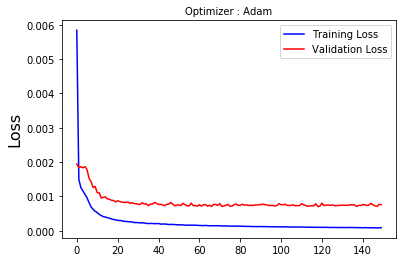

In [11]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [0]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = 'test.csv')

In [0]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

<font size = 3>figure</font>(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True)

*   num:影象編號或名稱，數字為編號 ，字串為名稱
* figsize:指定figure的寬和高，單位為英寸；
* dpi引數指定繪圖物件的解析度，即每英寸多少個畫素，預設值為80, 1英寸等於2.5cm, A4紙是 21*30cm的紙張 
* facecolor:背景顏色
* edgecolor:邊框顏色
* frameon:是否顯示邊框

------------------------------------------------------------------------------

add_subplot()的作用與subplot一樣，用於新增子圖。具體如下：

1. 新建figure物件
2. fig=plt.figure()
3. 新建子圖1，（2，2，1）表示建立2x2子圖中的第一個
4. ax1=fig.add_subplot(2,2,1)

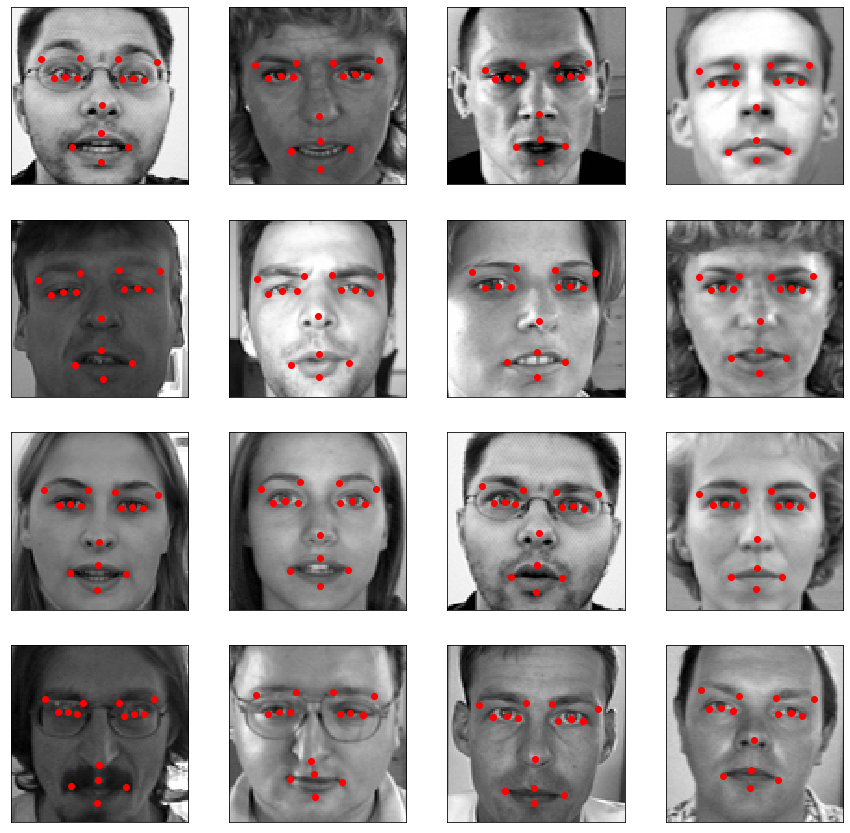

In [14]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [0]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [0]:
# Your code
import cv2

In [0]:
def agument_data(imgs, points):
  
  rows, cols = imgs.shape # imgs.shape = (96, 96)
  agu_imgs = np.copy(imgs)

  # 照片反轉
  for i in range(rows) :
    for j in range(cols // 2):
      agu_imgs[i][cols - j - 1] = imgs[i][j]
      agu_imgs[i][j] = imgs[i][cols - j - 1]

  # 翻轉關鍵點 label
  agu_points = np.copy(points)
  for i in range(0,len(points),2):
      agu_points[i] = -points[i]
  
  # 調整對稱的 label
  # revert right and left in label
  agu_points_temp = np.copy(agu_points)
  # eye_center
  agu_points[0:2] = agu_points_temp[2:4]
  agu_points[2:4] = agu_points_temp[0:2]
  # eye_inner_corner
  agu_points[4:6] = agu_points_temp[8:10]
  agu_points[8:10] = agu_points_temp[4:6]
  # eye_outer_corner
  agu_points[6:8] = agu_points_temp[10:12]
  agu_points[10:12] = agu_points_temp[6:8]
  # eyebrow_inner_end
  agu_points[12:14] = agu_points_temp[16:18]
  agu_points[16:18] = agu_points_temp[12:14]
  # eyebrow_outer_end
  agu_points[14:16] = agu_points_temp[18:20]
  agu_points[18:20] = agu_points_temp[14:16]
  # mouth_corner
  agu_points[22:24] = agu_points_temp[24:26]
  agu_points[24:26] = agu_points_temp[22:24]
  return agu_imgs, agu_points

In [0]:
flip_imgs_train = imgs_train
flip_points_train = points_train

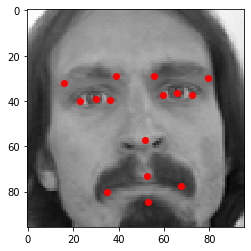

In [19]:
# flip_imgs_train.shape = (2140, 96, 96) flip_imgs_train[0].shape = (96, 96)
agum_imgs_train, agum_points_train = agument_data(flip_imgs_train[0], flip_points_train[0])

# fig = plt.figure()
# ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_keypoints(agum_imgs_train, agum_points_train)

In [20]:
# 新增資料
new_imgs_train = []
new_points_train = []

for i in range (flip_imgs_train.shape[0]):
  agum_imgs_train, agum_points_train = agument_data(flip_imgs_train[i], flip_points_train[i])

  # 加進原資料
  new_imgs_train.append(imgs_train[i])
  new_points_train.append(points_train[i])

  # 加進新資料
  new_imgs_train.append(agum_imgs_train)
  new_points_train.append(agum_points_train)

#  list 轉 array
new_imgs_train = np.array(new_imgs_train)
new_points_train = np.array(new_points_train)

print('new_imgs_train :', new_imgs_train.shape)
print('new_points_train :', new_points_train.shape)

new_imgs_train : (4280, 96, 96)
new_points_train : (4280, 30)


In [21]:
# model checkpoint 
checkpoint_agu = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)

# training the model
hist_model_agu = model_with_augment.fit(new_imgs_train.reshape(new_imgs_train.shape[0], 96, 96, 1), new_points_train, 
                           validation_split=0.2, batch_size=64, callbacks=[checkpoint_agu, hist],
                           shuffle=True, epochs=50, verbose=1)

Train on 3424 samples, validate on 856 samples
Epoch 1/50
3424/3424 [==============================] - 1s 395us/step - loss: 0.0038 - val_loss: 0.0020

Epoch 00001: val_loss improved from inf to 0.00201, saving model to best_weights.h5
Epoch 2/50
3424/3424 [==============================] - 1s 199us/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00201 to 0.00186, saving model to best_weights.h5
Epoch 3/50
3424/3424 [==============================] - 1s 196us/step - loss: 0.0011 - val_loss: 0.0017

Epoch 00003: val_loss improved from 0.00186 to 0.00173, saving model to best_weights.h5
Epoch 4/50
3424/3424 [==============================] - 1s 196us/step - loss: 9.1072e-04 - val_loss: 0.0016

Epoch 00004: val_loss improved from 0.00173 to 0.00161, saving model to best_weights.h5
Epoch 5/50
3424/3424 [==============================] - 1s 192us/step - loss: 7.0941e-04 - val_loss: 0.0013

Epoch 00005: val_loss improved from 0.00161 to 0.00130, saving model to 

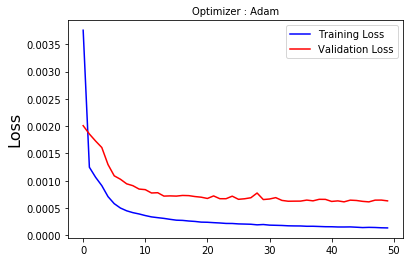

In [22]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model_agu.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model_agu.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')